# Swimming of early larval stages in still water and shear 
This is a graphical interface for using the pyVRS (Python Volume-Rendered Swimmer) model of low-Reynolds number hydrodynamics. It has a simplified interface for entering parameters to investigate stability and movement of early-stage larval morphologies approximated by "chimeras" of semi-ellipsoids. These early larval shapes are constructed by joining two half-ellipsoids about a common central radius. 

By choosing different ellipsoid shapes (larger vs. smaller central radii; longer vs. shorter semi-ellipsoids, etc.) you can construct different surface shapes that resemble the outside surfaces and tissue densities of early stages in larval development. You can also add inclusions, constructed from two half-ellipsoids, and assign them different densities to model the effects of internal volumes filled with seawater, calcium carbonate, lipid, or other materials.

The resulting shapes do not represent any particular species and stage exactly, but they approximate eggs, gastrulae and blastulae from a wide diversity of species and stages. This makes them good tools for exploring the consequences of size, morphological and physiological features, and properties of the fluid environment such as shear.

## How to use this notebook
This notebook is set up with "cells" that contain either Python code or explanatory text. You can see the cells by the bars and numbers on the left side of the notebook window.

- **To start the model, pull down the `Run` menu and select `Run All Cells`**
- **To execute a code cell, select it and hold down the shift key while typing the `enter` key.**
- **To reset the model to its initial state, pull down the `Run` menu and select `Restart Kernel and Run All Cells`**

When the model starts, it creates a larval shape using default parameters. That shape is shown in a separate, resizable graphics window. You can:
- **Click and drag on graphics windows to control the viewing angle.**
- **Click on the floppy disk icon to save graphics windows as images. Use informative names like `default_shape.svg` so that you can tell one image from another later on.**

To run the simulation:
- **Scroll down and click the `Reset` button to create a new simulation window.**
- **Click the `Run` button to execute and visualize the simulation.**
- **To run another simulation using the same simulation window, change e.g. the shear or ciliary velocity and click the `Run` button again. Make sure to press the `enter` key after you change parameters.
- **To run another simulation using a new simulation window, click the `Reset` button and then the `Run` button.

To change larval shape: 
- **Scroll to the shape parameter input boxes (there are separate parameter sets for the larval surface and inclusions).**
- **Change one or more shape parameters, and re-execute the code cell below to calculate and visualize the shape.**
- **When you are satisfied with the shape, re-execute the next code cells to recalculate flow around the new shapes.**
- **Run the simulation as before, with `Reset` to create a new simulation window and `Run` to visualize swimming trajectories.**

In [1]:
# Set up graphics environment
#%matplotlib inline
#%matplotlib notebook
#import IPython
%matplotlib ipympl
from mpl_toolkits import mplot3d
from matplotlib import pyplot
from matplotlib.colors import LightSource
#pyplot.ioff()
#pyplot.ion()
# Import modules
import numpy as np
from math import pi
import os
import EllipsoidSwim.pyVRSmorph as mrph
import EllipsoidSwim.pyVRSflow as flw
from EllipsoidSwim.meshEllipsoid import chimeraEllipsoid
# Import widget infrastructure
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython import display as idisplay

In [2]:
# Create a class and global instances for morphology parameters
global surf_pars, incl1_pars, incl2_pars
class CEpars():
    """
    A simple class to facilitate acquiring and passing chimera ellipsoid
    parameters with interactive_output widgets.
    """
    def __init__(self,a=50.e-6,b0=100.e-6,b1=-40.e-6,d=6e-6,nlevel0=16,nlevel1=12,
                      translate0=0.,translate1=0.,translate2=0.):
        self.a = a
        self.bs = [b0,b1]
        self.d = d
        self.nlevels = [nlevel0,nlevel1]
        self.translate = [translate0,translate1,translate2]

def set_surf_pars(a,b0,b1,d,nlevel0,nlevel1):
    global surf_pars
    surf_pars=CEpars(a=a,b0=b0,b1=b1,d=d,nlevel0=nlevel0,nlevel1=nlevel1)

def set_incl1_pars(a,b0,b1,d,nlevel0,nlevel1,translate0,translate1,translate2):
    global incl1_pars
    incl1_pars=CEpars(a=a,b0=b0,b1=b1,d=d,nlevel0=nlevel0,nlevel1=nlevel1,
                      translate0=translate0,translate1=translate1,translate2=translate2)

def set_incl2_pars(a,b0,b1,d,nlevel0,nlevel1,translate0,translate1,translate2):
    global incl2_pars
    incl2_pars=CEpars(a=a,b0=b0,b1=b1,d=d,nlevel0=nlevel0,nlevel1=nlevel1,
                      translate0=translate0,translate1=translate1,translate2=translate2)

In [3]:
# Create a class and global instances for simulation parameters
global sim_pars
class SimPars():
    """
    A simple class to facilitate acquiring and passing VRS simulation
    parameters with interactive_output widgets.
    """
    def __init__(self,dudz=0.,dvdz=0.,dwdx=0.,U0=0.,U1=0.,U2=0.,
                 Tmax=20.,cil_speed=0.5*1000*1e-6,
                 phi=pi/3.,theta=-pi/4.,psi=pi):
        self.dudz = dudz
        self.dvdz = dvdz
        self.dwdx = dwdx
        self.U0 = U0
        self.U1 = U1
        self.U2 = U2
        self.Tmax = Tmax
        self.cil_speed = cil_speed
        self.S_fixed = np.asarray([0.,0.,dudz,0.,0.,dvdz,dwdx,0.,0.])
        self.U_const_fixed = np.asarray([U0,U1,U2])
        self.XEinit = np.asarray([0.,0.,0.,phi,theta,psi])

def set_sim_pars(dudz,dvdz,dwdx,Tmax,cil_speed,phi,theta,psi):
    global sim_pars
    sim_pars=SimPars(dudz=dudz,dvdz=dvdz,dwdx=dwdx,
                 Tmax=Tmax,cil_speed=cil_speed,
                 phi=phi,theta=theta,psi=psi)

print('Simulation parameters class defined...')

Simulation parameters class defined...


## Define the outer larval shape 
![alt text](embryo2labels.png "Surface shape parameters")

The text boxes below enable you to set the shape parameters for the outside of a model larva. To change parameters, enter a new value and hit `enter`. The parameters are:
- $a$: central radius
- $b_0$: length of the top semi-ellipse
- $b_1$: length of the bottom semi-ellipse (a negative number, because this semi-ellipse points downwards)

Additional parameters (that you may not have to adjust) specify the layout of triangles on the larval surface. 
- $d$, a parameter specifying the number of columns of triangles on the top and bottom parts of the larval surface 
- $n_0$ and $n_1$ specify the number of rows of triangles on the top and bottom parts of the larval surface


In [4]:
# Set parameters for surface chimera
surf_a=widgets.FloatText(value=50.e-6,width=10,description = r"$a$")
surf_d=widgets.FloatText(value=6.e-6,description = r"$d$")
surf_b0=widgets.FloatText(value=100.e-6,description = r"$b_0$")
surf_nlevel0=widgets.IntText(value=16,description = r"$n_0$")
surf_b1=widgets.FloatText(value=-40.e-6,description = r"$b_1$")
surf_nlevel1=widgets.IntText(value=12,description = r"$n_1$")

ui0 = widgets.VBox([surf_a,surf_d])
ui1 = widgets.VBox([surf_b0,surf_nlevel0])
ui2 = widgets.VBox([surf_b1,surf_nlevel1])
ui012 = widgets.HBox([ui0,ui1,ui2])

out = widgets.interactive_output(set_surf_pars,{'a':surf_a,'b0':surf_b0,'b1':surf_b1,'d':surf_d,
                                                'nlevel0':surf_nlevel0,'nlevel1':surf_nlevel1})
display(ui012,out)

Output()

## Define an inclusion 
The text boxes below enable you to set the shape parameters for inclusions inside a model larva. The parameters have the same interpretations as for the outer shape:
- $a$: central radius
- $b_0$: length of the top semi-ellipse
- $b_1$: length of the bottom semi-ellipse (a negative number, because this semi-ellipse points downwards)

Additional parameters (that you may not have to adjust) specify the layout of triangles on the inclusion. 
- $d$, a parameter specifying the number of columns of triangles on the top and bottom parts of the inclusion 
- $n_0$ and $n_1$ specify the number of rows of triangles on the top and bottom parts of the inclusion

Make sure the surfaces do not intersect (that is, the inclusion is entirely within the outer surface, etc.)!

In [5]:
# Set parameters for the inclusion chimera
incl1_a=widgets.FloatText(value=30.e-6,width=10,description = r"$a$")
incl1_d=widgets.FloatText(value=5.e-6,description = r"$d$")
incl1_b0=widgets.FloatText(value=50.e-6,description = r"$b_0$")
incl1_nlevel0=widgets.IntText(value=12,description = r"$n_0$")
incl1_b1=widgets.FloatText(value=-20.e-6,description = r"$b_1$")
incl1_nlevel1=widgets.IntText(value=8,description = r"$n_1$")
incl1_translate0=widgets.FloatText(value=0.,description = r"$x$ offset")
incl1_translate1=widgets.FloatText(value=0.,description = r"$y$ offset")
incl1_translate2=widgets.FloatText(value=40.e-6,description = r"$z$ offset")

#translate=[0.,0.,40.e-6]

ui0i = widgets.VBox([incl1_a,incl1_d,incl1_translate0])
ui1i = widgets.VBox([incl1_b0,incl1_nlevel0,incl1_translate1])
ui2i = widgets.VBox([incl1_b1,incl1_nlevel1,incl1_translate2])
ui012i = widgets.HBox([ui0i,ui1i,ui2i])


outi = widgets.interactive_output(set_incl1_pars,{'a':incl1_a,'b0':incl1_b0,'b1':incl1_b1,'d':incl1_d,
                                                'nlevel0':incl1_nlevel0,'nlevel1':incl1_nlevel1,
                                                'translate0':incl1_translate0,
                                                'translate1':incl1_translate1,
                                                'translate2':incl1_translate2})
display(ui012i,outi)

Output()

## Compute the larval shape
Execute this code cell to plot out the shape of the larva specified by the parameters you entered in the input boxes above. If you're happy with the goemetry, proceed to the next step. If not, change the parameters and re-execute this cell again to display the new shape.

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
Added peak tile...
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
Added peak tile...
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
Added peak tile...
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
Added peak tile...
Created Medium object with parameters:
AttrDict({'density': 1030.0, 'material': 'seawater', 'immersed_in': False, 'contains': [], 'scale_factor': 1, 'offset': array([0, 0, 0]), 'rotate': array([0, 0, 0, 0]), 'layer_type': 'medium', 'transformations': [], 'stlfile': None, 'nu': 1.17e-06, 'mu': 0.0012051})
Created Surface object with parameters:
AttrDict({'density': 1070.0, 'material': 'tissue', 'immersed_in': 0, 'contains': [], 'scale_factor': 1, 'offset': array([0, 0, 0]), 'rotate': array([0, 0, 0, 0]), 'layer_type': 'surface', 'transformations': [], 'stlfile': None, 'total_area': 4.036756213581691e-08, 'total_volume'

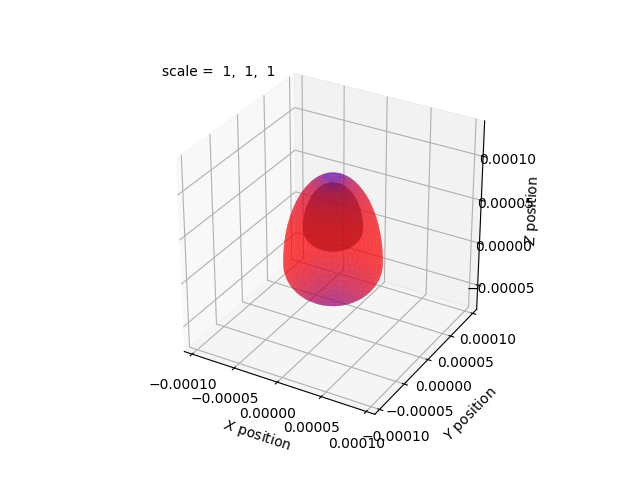

In [6]:
CEsurf = chimeraEllipsoid(a=surf_pars.a,bs=surf_pars.bs,d=surf_pars.d,nlevels=surf_pars.nlevels)
CEincl = chimeraEllipsoid(a=incl1_pars.a,bs=incl1_pars.bs,d=incl1_pars.d,nlevels=incl1_pars.nlevels,translate=incl1_pars.translate)
M = mrph.Morphology()
M.check_normals = False
M.gen_surface(vectors=CEsurf.vectors)
# materials parameter can be 'seawater', 'tissue', 'lipid' or 'calcite' 
M.gen_inclusion(vectors=CEincl.vectors,material='freshwater',immersed_in=1)
figure = pyplot.figure()
axes = figure.add_subplot(projection='3d')
M.plot_layers(axes=axes)

## Compute the fluid forces
Executing this cell will compute the geometry and fluid flow around the model larva. 

Depending on the number of triangle and the speed of your computer, it may take a few seconds to complete: 
- When it starts calculating, it prints out "Calculating inverse...". 
- When the calculation is complete, it prints out "Done calculating inverse."
- The output includes statistics like the magnitudes and centers of buoyancy and gravity.

**You need to run this just once for each larval shape. You do not need to rerun it unless you change the larval shape.**

In [7]:
M.body_calcs()
M.flow_calcs(surface_layer=1)

Layer 0 of type <class 'EllipsoidSwim.pyVRSmorph.Medium'>
Layer 1 of type <class 'EllipsoidSwim.pyVRSmorph.Surface'>
F_buoyancy =  7.3585882629207806e-09
C_buoyancy =  [ 2.90713553e-21 -7.19504260e-22  2.24745998e-05]
List of all inclusions is:  [2]
F_gravity =  -7.55501048203754e-09
C_gravity =  [ 2.94645255e-21 -7.34206082e-22  2.21345526e-05]
Layer 2 of type <class 'EllipsoidSwim.pyVRSmorph.Inclusion'>
Assembling influence matrix
Calculating inverse...
Done calculating inverse.


## Define the simulation parameters
This cell sets parameters for simulating how the larval shape swims under different flow conditions.

The parameters are:
- $\frac{dU}{dz}$: change of horizontal velocity ($U$) across depth ($z$)
- $\frac{dV}{dz}$: change of horizontal velocity ($V$) across depth ($z$)
- $\frac{dW}{dx}$: change of vertical velocity ($W$) in the $x$ direction
- $\phi$, $\theta$, $\psi$: initial Euler angle
- $T_{max}$: duration of time to simulate
- $V_{cilia}$: velocity of cilia on the larval surface (red: maximum speed; blue: 0 speed)

In [8]:
# Set simulation parameters
spars_dudz=widgets.FloatText(value=0.,width=10,description = r"$\frac{dU}{dz}$")
spars_dvdz=widgets.FloatText(value=0.,description = r"$\frac{dV}{dz}$")
spars_dwdx=widgets.FloatText(value=0.,description = r"$\frac{dW}{dx}$")
spars_Tmax=widgets.FloatText(value=10,description = r"$T_{max}$")
spars_cil_speed=widgets.FloatText(value=500.e-6,description = r"$V_{cilia}$")
spars_phi=widgets.FloatText(value=pi/3.,description = r"$\phi$")
spars_theta=widgets.FloatText(value=pi/4.,description = r"$\theta$")
spars_psi=widgets.FloatText(value=pi,description = r"$\psi$")

#translate=[0.,0.,40.e-6]

ui0s = widgets.VBox([spars_dudz,spars_phi,spars_Tmax])
ui1s = widgets.VBox([spars_dvdz,spars_theta,spars_cil_speed])
ui2s = widgets.VBox([spars_dwdx,spars_psi])
ui012s = widgets.HBox([ui0s,ui1s,ui2s])


outs = widgets.interactive_output(set_sim_pars,{'dudz':spars_dudz,'dvdz':spars_dvdz,'dwdx':spars_dwdx,'Tmax':spars_Tmax,
                                                'cil_speed':spars_cil_speed,'phi':spars_phi,
                                                'theta':spars_theta,
                                                'psi':spars_psi})
display(ui012s,outs)

Output()

## Run the simulation
Hit the **reset** button to create a new simulation window. 

Hit **run** to simulate swimming of the larval shape you defined using the flow parameters you defined.

In this window, the left hand side plot shows the trajectory of the larva (blue lines), starting at the position (0,0,0) which is marked with a red dot. The simulated time, and the larval position and velocity are given at the top of the plot.

The right hand side plot shows the orientation of the larval shape. The Euler angles specifying the larva's orientation are given at the top of the plot.

The simulation will plot multiple trajectories in the same plot, to make it easy to compare the effects of different shear rates. You can save the plot using the disk icon at the top of the simulation window. 

In [9]:
global Sim
button = widgets.Button(description="Reset")
output = widgets.Output()
button2 = widgets.Button(description="Run")
output2 = widgets.Output()

buttons = widgets.HBox([button, output, button2, output2])
display(buttons)

@output.capture()
def on_button_clicked(b):
    global Sim, sim_pars
    Sim = flw.VRSsim(morph=M)

@output2.capture()
def on_button_clicked2(b):
    global Sim,sim_pars
    Sim.run(XEinit=sim_pars.XEinit,Tmax=sim_pars.Tmax,cil_speed=sim_pars.cil_speed,U_const_fixed=sim_pars.U_const_fixed,S_fixed=sim_pars.S_fixed)

button.on_click(on_button_clicked)
button2.on_click(on_button_clicked2)